

### **1. Project Introduction.**



Credit Scorecard Development for Lending or Credit Cards
This notebook walks through the development of a credit scorecard used in lending or credit card decisioning.
The scorecard assigns a score to each customer that reflects their likelihood of default.

# **2. Data Loading & Initial Exploration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

In [ ]:
# Generate synthetic data
np.random.seed(42)
n = 10000
data = pd.DataFrame({
    'age': np.random.randint(21, 70, size=n),
    'income': np.random.normal(50000, 15000, size=n),
    'loan_amount': np.random.normal(15000, 5000, size=n),
    'marital_status': np.random.choice(['single', 'married', 'divorced'], size=n),
    'education': np.random.choice(['high_school', 'bachelor', 'master', 'phd'], size=n),
    'default': np.random.binomial(1, 0.2, size=n)
})

In [ ]:
# Inspect data
data.head()
data.describe()
data.info()
data['default'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             10000 non-null  int64  
 1   income          10000 non-null  float64
 2   loan_amount     10000 non-null  float64
 3   marital_status  10000 non-null  object 
 4   education       10000 non-null  object 
 5   default         10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 468.9+ KB


,proportion
default,
0,0.7985
1,0.2015


# **3. Data Preprocessing**

In [ ]:
# Handle missing values
# (Synthetic dataset has no missing values, but in real scenarios use imputation)

# Encode categorical variables
categorical = ['marital_status', 'education']
data = pd.get_dummies(data, columns=categorical, drop_first=True)

# Split data
X = data.drop('default', axis=1)
y = data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# **4. Exploratory Data Analysis (EDA)**

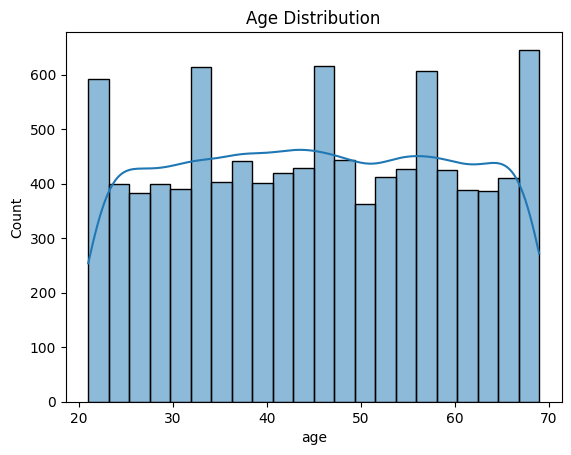

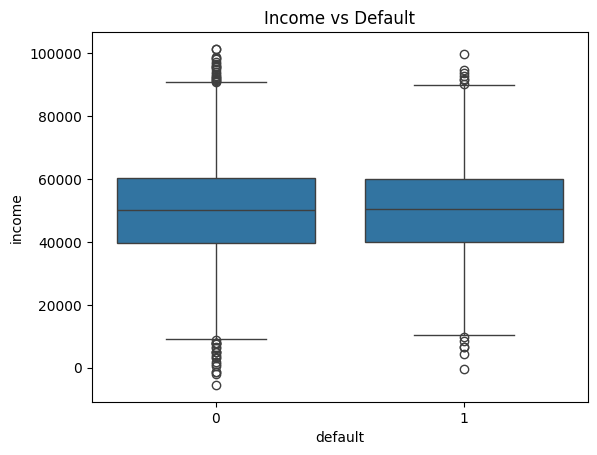

In [ ]:
sns.histplot(data['age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.boxplot(x='default', y='income', data=data)
plt.title('Income vs Default')
plt.show()

## **5. Feature Engineering: Binning + WOE + IV**

In [ ]:
# Manual binning for age
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70']
data['age_bin'] = pd.cut(data['age'], bins=bins, labels=labels)

# WOE encoding (simplified)
def calc_woe_iv(df, feature, target):
    lst = []
    for i in df[feature].unique():
        good = len(df[(df[feature] == i) & (df[target] == 0)])
        bad = len(df[(df[feature] == i) & (df[target] == 1)])
        lst.append({'Value': i, 'Good': good, 'Bad': bad})
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WOE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WOE']
    return dset, dset['IV'].sum()

woe_table, iv_age = calc_woe_iv(data, 'age_bin', 'default')
print(woe_table)
print(f'IV for Age: {iv_age}')

   Value  Good  Bad  Distr_Good  Distr_Bad       WOE            IV
0  50-60  1630  411    0.204133   0.203970  0.000796  1.294505e-07
1  40-50  1650  453    0.206637   0.224814 -0.084307  1.532405e-03
2  30-40  1659  404    0.207765   0.200496  0.035610  2.588222e-04
3  60-70  1464  367    0.183344   0.182134  0.006620  8.009022e-06
4  20-30  1582  380    0.198121   0.188586  0.049328  4.703883e-04
IV for Age: 0.00226975366914645


### **6. Model Development: Logistic Regression**


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Coefficients
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print(coeff_df)

                  Feature   Coefficient
0                     age  2.813100e-03
1                  income  8.219919e-09
2             loan_amount -9.570627e-06
3  marital_status_married  3.061907e-01
4   marital_status_single  1.752068e-01
5   education_high_school -1.073381e-01
6        education_master -5.908468e-02
7           education_phd -9.299762e-02


## **7. Evaluation**

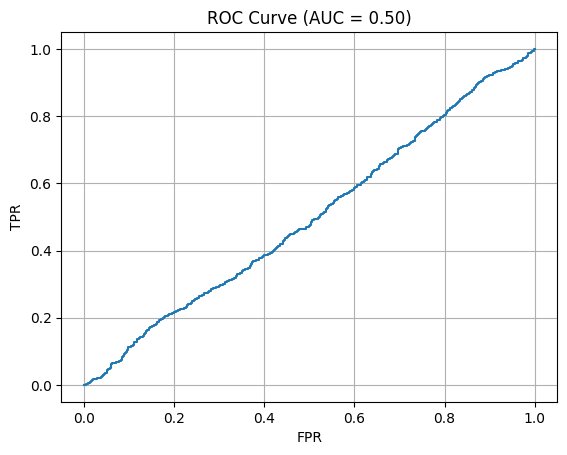

[[2396    0]
 [ 604    0]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2396
           1       0.00      0.00      0.00       604

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.64      0.80      0.71      3000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.title(f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## **8. Score Scaling**

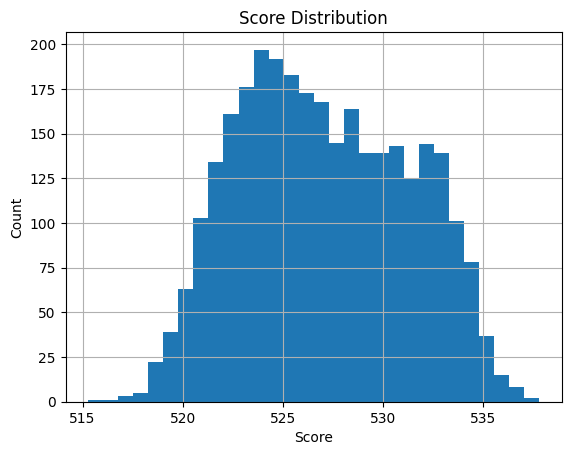

In [ ]:
# Base Score and PDO
import math
PDO = 20
base_score = 600
base_odds = 50  # Odds of good:bad at base score
factor = PDO / np.log(2)
offset = base_score - factor * np.log(base_odds)

# Score for each individual
log_odds = model.intercept_[0] + np.dot(X_test, model.coef_.T)
scores = offset + factor * (-log_odds)

plt.hist(scores, bins=30)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.grid()
plt.show()

## **9. Business Interpretation**

A higher score means lower likelihood of default.
We can set a cutoff (e.g., 600) to approve/reject applicants.

10. Conclusion
# ------------------------------------------------------------
We built a scorecard using logistic regression, WOE encoding, and score scaling.
It can be used in production with monitoring and periodic recalibration.
